# Organic Photovoltaic Data Set

This notebook accompanies the publication entitled "How important is microstructural feature selection for data-driven structure-property mapping?" [1]. The goal of this notebook is to demonstrate feature engineering and model building using 2-point stats and PCA. The data set is an artificial open-source data set of a photovoltaic microstructures generated by a Cahn-Hilliard model [2]. The `x_data` is the microstructure and the `y_data` is a global property, namely the short circuit current, $J_{sc}$, calculated using a drift diffusion numerical model. The notebook compares using a standard 2-point stats and PCA workflow with an expert-enriched approach where the 2-point stats are engineered with knowledge of the geometry and physics of the application.

[1]: link-to-paper
[2]: link-to-data

In [1]:
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.decomposition import PCA
from dask_ml.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from dask_ml.model_selection import train_test_split
from dask_ml.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression

from mpl_toolkits.mplot3d import Axes3D

from pymks import (
    plot_microstructures,
    PrimitiveTransformer,
    TwoPointCorrelation,
    FlattenTransformer,
    GenericTransformer

)
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load Data

The data is stored in a CSV file of shape 1708x40501 where each row is a flattened 2D microstructure of shape 101x401. The data is stored in `pv_microstructure_data.csv`. We use Pandas to read the CSV file and then convert it to a Dask array with 100 chunks per process.

In [3]:
n_chunks = 100
n_sample_size = 1700

In [4]:
raw_data = pd.read_csv('pv_microstructure_data.csv').to_numpy()

In [5]:
np.random.seed(105)

ind = np.random.choice(raw_data.shape[0], n_sample_size)

In [6]:
x_data = da.from_array(raw_data[ind], chunks=(n_chunks, -1))

In [7]:
x_data

dask.array<array, shape=(1700, 40501), dtype=int64, chunksize=(100, 40501), chunktype=numpy.ndarray>

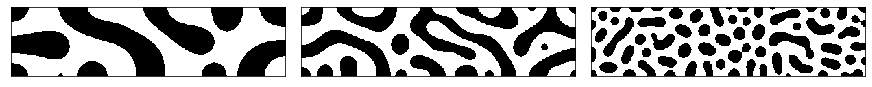

In [8]:
plot_microstructures(
    x_data[0].reshape(101, 401),
    x_data[x_data.shape[0] // 2].reshape(101, 401),
    x_data[x_data.shape[0] - 1].reshape(101, 401),
    colorbar=False,
    cmap='gray'
)

In the images above the upper boundary is an anode and the bottom boundary is a cathode. This knowledge will be used to better design the features in the following analysis. White pixels represent donor material and black pixels represent acceptor material. Each sample is generated with slightly different parameters in the Cahn-Hilliard model resulting in different microstructure coarseness.

The  $J_{sc}$ property is stored in `y_data.npy` as a negative number, but needs to be postive to work with the ML models.

In [9]:
y_data = da.from_array(-np.load('y_data.npy').reshape(-1)[ind], chunks=(n_chunks,))

In [10]:
y_data

dask.array<array, shape=(1700,), dtype=float64, chunksize=(100,), chunktype=numpy.ndarray>

## Split Data

The following splits the data into train and test sets. Each chunk in the Dask array is split 80/20.

In [11]:
split_data = x_train, x_test, y_train, y_test = train_test_split(
    x_data,
    y_data,
    test_size=0.2,
    random_state=12
)

In [12]:
x_train

,Array,Chunk
Bytes,440.65 MB,972.02 kB
Shape,"(1360, 40501)","(3, 40501)"
Count,1299 Tasks,1281 Chunks
Type,int64,numpy.ndarray


In [13]:
y_train

,Array,Chunk
Bytes,10.88 kB,24 B
Shape,"(1360,)","(3,)"
Count,1299 Tasks,1281 Chunks
Type,float64,numpy.ndarray


## Preprocess Data A

Before fitting the data we can execute one-hot encoding and 2-point stats as preprocess steps as they do not influence the cross-validation.

In [14]:
preprocess_steps = [
    ("reshape", GenericTransformer(lambda x: x.reshape(x.shape[0], 101, 401))),
    ("discritize", PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ("correlations", TwoPointCorrelation(periodic_boundary=True, cutoff=50, correlations=[(0, 0)])),
    ('flatten', GenericTransformer(lambda x: x.reshape(x.shape[0], -1)))
]

In [15]:
x_data_preprocess = Pipeline(preprocess_steps).transform(x_data).persist()

The `x_data_preprocess` has been "persisted", which means that it has been calculated and stored separately in each worker.

In [16]:
x_data_preprocess

dask.array<reshape, shape=(1700, 10201), dtype=float64, chunksize=(100, 10201), chunktype=numpy.ndarray>

## Generate Models

We create a function that generates either a basic model with no enriched features or a model with enriched features using the `enriched` argument. Here `FeatureUnion` is used in the pipeline to combine in the enriched features. The enriched features are the 1D 2-point stats along the top and bottom layer (the anode and cathode). We use the `GenericTransformer` to extract this data before the correlation step.

In [17]:
def generate_model(degree, n_components, enriched=False):
    primitive = Pipeline([
        ("reshape", GenericTransformer(lambda x: x.reshape(x.shape[0], 101, 401))),
        ("discritize", PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0))
    ])

    correlations_base = Pipeline([
        ("correlations", TwoPointCorrelation(periodic_boundary=True, cutoff=50, correlations=[(0, 0)])),
        ('flatten', GenericTransformer(lambda x: x.reshape(x.shape[0], -1)))
    ])

    correlations_anode = Pipeline([
        ("select_top", GenericTransformer(lambda x: x[:, 0])),
        ("correlations", correlations_base)
    ])
     
    correlations_cathode = Pipeline([
        ("select_bottom", GenericTransformer(lambda x: x[:, -1])),
        ("correlations", correlations_base)
    ])
    
    pca_regressor = Pipeline([
        ('pca',PCA(n_components=n_components, svd_solver='full', random_state=999)),
        ('poly', PolynomialFeatures(degree=degree)),
        ('regressor', LinearRegression())
    ])

    if enriched:
        correlations = FeatureUnion([
            ('base', correlations_base),
            ('anode', correlations_anode),
            ('cathode', correlations_cathode)
        ])
    else:
        correlations = correlations_base
    
    return Pipeline([
        ("primitive", primitive),
        ("correlations", correlations),
        ('pca_regressor', pca_regressor)
    ])

## Check Models

The following checks that the models are sensible for some non-optimized parameters of `n_components = 11` and no polynomial additional terms (i.e. `degree=2`) 

In [18]:
def parity_plot(y_train, y_predict_train, y_test, y_predict_test, title):
    plt.plot(y_train, y_predict_train, 'o', label='Training Data',color='blue')
    plt.plot(y_test, y_predict_test, 'o', label='Testing Data',color='red')
    plt.plot(
        [np.min(y_train), np.max(y_train)],
        [np.min(y_train), np.max(y_train)],
        color='g', lw=3,linestyle='--'
    )
    plt.xlabel('y_actual')
    plt.ylabel('y_predict')
    plt.title(title)
    plt.legend();

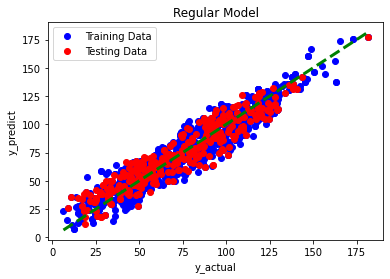

In [19]:
regular_model = generate_model(2, 11, enriched=False)

regular_model.fit(x_train, y_train)
y_predict_train = regular_model.predict(x_train)
y_predict_test = regular_model.predict(x_test)

parity_plot(y_train, y_predict_train, y_test, y_predict_test, 'Regular Model')

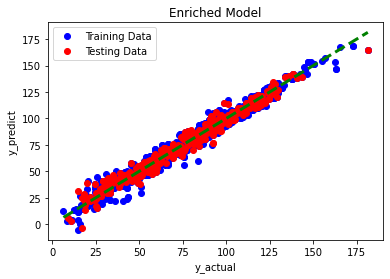

In [20]:
enriched_model = generate_model(2, 11, enriched=True)

enriched_model.fit(x_train, y_train)
y_predict_train = enriched_model.predict(x_train)
y_predict_test = enriched_model.predict(x_test)

parity_plot(y_train, y_predict_train, y_test, y_predict_test, 'Enriched Model')

## Cross-validation

In [21]:
def nmae(y0, y1):
    return np.mean(abs(y0 - y1)) / np.mean(y1)

def get_scores(params, model, x_train, x_test, y_train, y_test):
    model = model.fit(x_train, y_train)
        
    y_predict = model.predict(x_test)
    y_train_predict = model.predict(x_train)
    
    mse = -cross_val_score(
        model,
        x_train,
        y_train,
        cv=5,
        scoring='neg_mean_squared_error'
    )
        
    r2 = cross_val_score(
        model,
        x_train,
        y_train,
        cv=5,
        scoring='r2'
    )
    
    scores = dict(
        mse=mse,
        r2=r2,
        avg_r2=np.mean(r2),
        mse_test=metrics.mean_squared_error(y_test, y_predict),
        r2_test=metrics.r2_score(y_test, y_predict),
        nmae_train=nmae(y_train_predict, y_train).compute(),
        nmae_test=nmae(y_predict, y_test).compute(),
    )
    
    print('model:', params)
    print('scores:', scores)
    
    return scores

In [22]:
import itertools

grid_params = itertools.product(np.arange(1, 4), np.arange(10, 16), [True])

all_scores = dict(
    (params, get_scores(params, generate_model(*params), *split_data))
    for params in grid_params
)

model: (1, 10, True)
scores: {'mse': array([103.97840855,  86.40834169,  90.93548268, 102.56215552,
        93.92131245]), 'r2': array([0.90237927, 0.9073033 , 0.91438954, 0.90503314, 0.89403371]), 'avg_r2': 0.9046277933589977, 'mse_test': 101.5390620069202, 'r2_test': 0.8979395426800212, 'nmae_train': 0.09607162742023134, 'nmae_test': 0.10378608862736163}
model: (1, 11, True)
scores: {'mse': array([103.90992261,  86.21733868,  89.76718063, 101.29422421,
        92.38863117]), 'r2': array([0.90244357, 0.9075082 , 0.91548943, 0.90620717, 0.89576296]), 'avg_r2': 0.9054822662646156, 'mse_test': 99.51281929920539, 'r2_test': 0.8999761899889805, 'nmae_train': 0.09565916115393261, 'nmae_test': 0.10272301477831033}
model: (1, 12, True)
scores: {'mse': array([92.81609436, 82.80530588, 87.33290532, 95.8706252 , 88.26093864]), 'r2': array([0.91285908, 0.91116855, 0.91778116, 0.91122912, 0.90042001]), 'avg_r2': 0.9106915817613099, 'mse_test': 88.07885977292506, 'r2_test': 0.9114688620224366, 'nma

## Learning Curves

In [23]:
from sklearn.model_selection import learning_curve

In [24]:
samples, train_errors, test_errors = learning_curve(
    generate_model(2, 11, True),
    x_data,
    y_data,
    train_sizes=np.array([0.05, 0.1, 0.15, 0.2, 0.33, 0.55, 0.78, 1.0]),
    random_state=99
) 

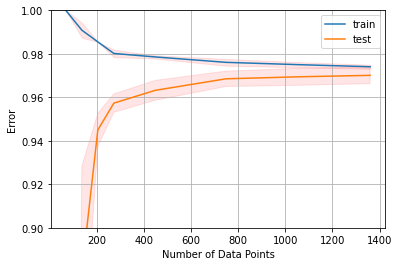

In [27]:
mean_train, mean_test = train_errors.mean(axis=1), test_errors.mean(axis=1)
std_train, std_test = train_errors.std(axis=1), test_errors.std(axis=1)

plt.plot(samples, mean_train, label='train')
plt.plot(samples, mean_test, label='test')
plt.fill_between(samples, mean_train - std_train, mean_train + std_train, alpha=0.1, color='r')
plt.fill_between(samples, mean_test - std_test, mean_test + std_test, alpha=0.1, color='r')
plt.ylim([0.9,1])
plt.legend()
plt.xlabel("Number of Data Points")
plt.ylabel("Error")
plt.grid()
plt.show()

## Sandbox Area